In [1]:
!pip install torchinfo
!nvidia-smi

Wed Jul 31 14:09:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)  # 출력결과: cuda
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [3]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.0001
BATCH_SIZE = 45
EPOCHS = 25
IMG_SIZE = 227
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5
LRN_K = 2.0
LRN_ALPHA = 0.0001
LRN_BETA = 0.75
LRN_N = 5

In [4]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [5]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [6]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [7]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [8]:
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False)
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [10]:
# AlexNet 현대적으로 재해석한 책에서 제시된 버전으로 구현 (multi-GPU 구현하지 않음, 배치정규화 차용)
class ModernAlexNet(nn.Module):
    def __init__(self):
        super(ModernAlexNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout(DROPOUT)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.fc6 = nn.Linear(6 * 6 * 256, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, NUM_CLASSES)

    def forward(self, x):
        # Conv 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Conv 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Conv 3
        x = F.relu(self.conv3(x))
        # Conv 4
        x = F.relu(self.conv4(x))
        # Conv 5
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        # FC 6
        x = x.view(-1, 6 * 6 * 256)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        # FC 7
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        # FC 8
        logits = self.fc8(x)
        return logits

torchinfo.summary(
    ModernAlexNet(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ModernAlexNet (ModernAlexNet)            [1, 3, 227, 227]          [1, 10]                   2,752                     --
├─Conv2d (conv1): 1-1                    [1, 3, 227, 227]          [1, 96, 55, 55]           34,944                    [11, 11]
├─MaxPool2d (pool): 1-2                  [1, 96, 55, 55]           [1, 96, 27, 27]           --                        3
├─Conv2d (conv2): 1-3                    [1, 96, 27, 27]           [1, 256, 27, 27]          614,656                   [5, 5]
├─MaxPool2d (pool): 1-4                  [1, 256, 27, 27]          [1, 256, 13, 13]          --                        3
├─Conv2d (conv3): 1-5                    [1, 256, 13, 13]          [1, 384, 13, 13]          885,120                   [3, 3]
├─Conv2d (conv4): 1-6                    [1, 384, 13, 13]          [1, 384, 13, 13]          1,327,488                 [3, 3

100%|██████████| 170498071/170498071 [00:03<00:00, 43778799.82it/s]


Extracting cifar10_data/cifar-10-python.tar.gz to cifar10_data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


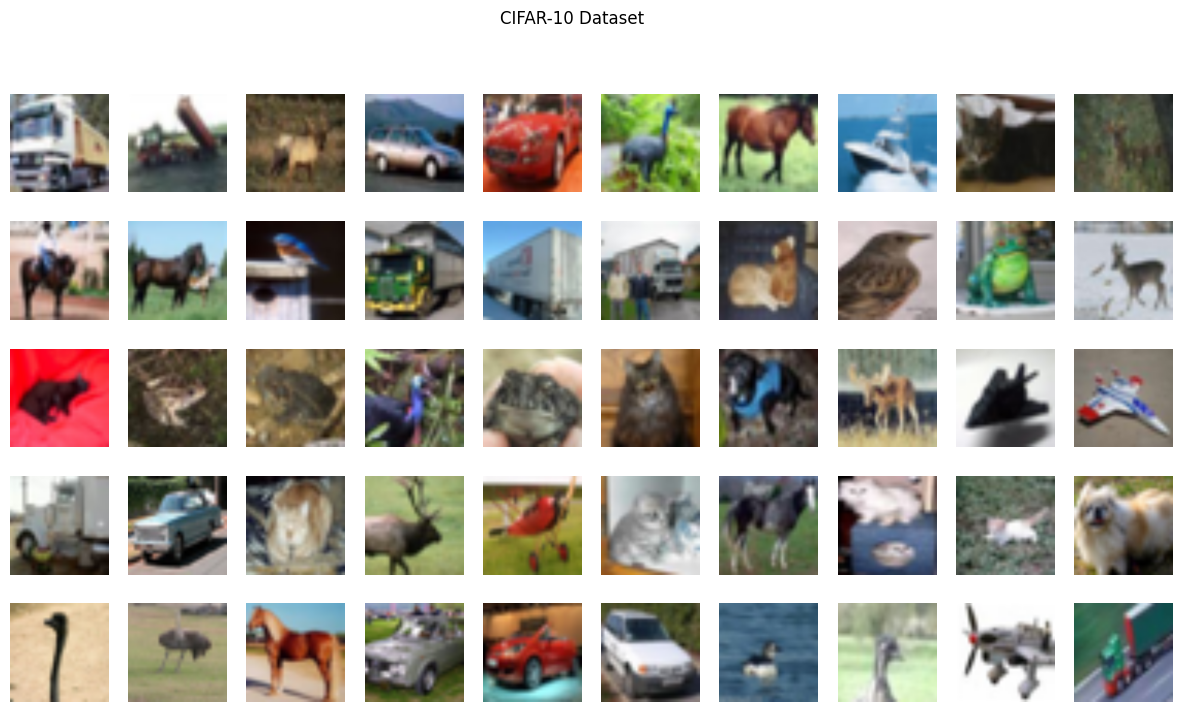

train dataset size:  42000
valid dataset size:  9000
test dataset size:  9000


In [11]:
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
full_dataset = datasets.CIFAR10(root="cifar10_data", train=True, transform=transform, download=True)
full_dataset = ConcatDataset([full_dataset, datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)])

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 CIFAR-10 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(15, 8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    img = train_dataset.dataset[index][0]
    img = img.permute(1, 2, 0)  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(img)

fig.suptitle("CIFAR-10 Dataset")
plt.show()

# 데이터셋 크기 출력
print("train dataset size: ", len(train_dataset))
print("valid dataset size: ", len(valid_dataset))
print("test dataset size: ", len(test_dataset))


23:14:39 --- Start Training Loop ---


23:17:45 ---  Epoch: 1	Train loss: 1.6447	Valid loss: 1.2963	Train accuracy: 52.75	Valid accuracy: 53.10


23:20:49 ---  Epoch: 2	Train loss: 1.1692	Valid loss: 0.9894	Train accuracy: 65.43	Valid accuracy: 65.09


23:23:51 ---  Epoch: 3	Train loss: 0.9595	Valid loss: 0.8649	Train accuracy: 71.41	Valid accuracy: 69.54


23:26:55 ---  Epoch: 4	Train loss: 0.8066	Valid loss: 0.7381	Train accuracy: 76.53	Valid accuracy: 74.98


23:30:00 ---  Epoch: 5	Train loss: 0.7041	Valid loss: 0.7421	Train accuracy: 76.78	Valid accuracy: 74.37


23:33:07 ---  Epoch: 6	Train loss: 0.6163	Valid loss: 0.6431	Train accuracy: 81.94	Valid accuracy: 78.73


23:36:14 ---  Epoch: 7	Train loss: 0.5463	Valid loss: 0.6046	Train accuracy: 84.27	Valid accuracy: 79.07


23:39:20 ---  Epoch: 8	Train loss: 0.4855	Valid loss: 0.5938	Train accuracy: 85.95	Valid accuracy: 80.07


23:42:26 ---  Epoch: 9	Train loss: 0.4277	Valid loss: 0.5558	Train accuracy: 87.84	Valid accuracy: 81.30


23:45:34 ---  Epoch: 10	Train loss: 0.3815	Valid loss: 0.5629	Train accuracy: 89.61	Valid accuracy: 81.58


23:48:39 ---  Epoch: 11	Train loss: 0.3361	Valid loss: 0.5248	Train accuracy: 92.08	Valid accuracy: 82.38


23:51:44 ---  Epoch: 12	Train loss: 0.2930	Valid loss: 0.5636	Train accuracy: 92.01	Valid accuracy: 82.44


23:54:48 ---  Epoch: 13	Train loss: 0.2590	Valid loss: 0.6098	Train accuracy: 92.61	Valid accuracy: 81.87


23:57:51 ---  Epoch: 14	Train loss: 0.2245	Valid loss: 0.5809	Train accuracy: 94.76	Valid accuracy: 83.53


00:00:55 ---  Epoch: 15	Train loss: 0.1993	Valid loss: 0.5666	Train accuracy: 95.52	Valid accuracy: 83.28


00:04:01 ---  Epoch: 16	Train loss: 0.1724	Valid loss: 0.5732	Train accuracy: 95.78	Valid accuracy: 83.68


00:07:05 ---  Epoch: 17	Train loss: 0.1561	Valid loss: 0.6396	Train accuracy: 97.03	Valid accuracy: 83.91


00:10:08 ---  Epoch: 18	Train loss: 0.1378	Valid loss: 0.6067	Train accuracy: 97.87	Valid accuracy: 84.13


00:13:14 ---  Epoch: 19	Train loss: 0.1252	Valid loss: 0.6678	Train accuracy: 97.48	Valid accuracy: 84.20


00:16:18 ---  Epoch: 20	Train loss: 0.1123	Valid loss: 0.6276	Train accuracy: 98.41	Valid accuracy: 84.51


00:19:22 ---  Epoch: 21	Train loss: 0.1011	Valid loss: 0.7084	Train accuracy: 98.15	Valid accuracy: 83.78


00:22:26 ---  Epoch: 22	Train loss: 0.0927	Valid loss: 0.6386	Train accuracy: 98.73	Valid accuracy: 84.90


00:25:30 ---  Epoch: 23	Train loss: 0.0927	Valid loss: 0.6633	Train accuracy: 98.79	Valid accuracy: 84.18


00:28:34 ---  Epoch: 24	Train loss: 0.0806	Valid loss: 0.7354	Train accuracy: 98.78	Valid accuracy: 84.26


00:31:38 ---  Epoch: 25	Train loss: 0.0790	Valid loss: 0.7516	Train accuracy: 98.48	Valid accuracy: 84.02


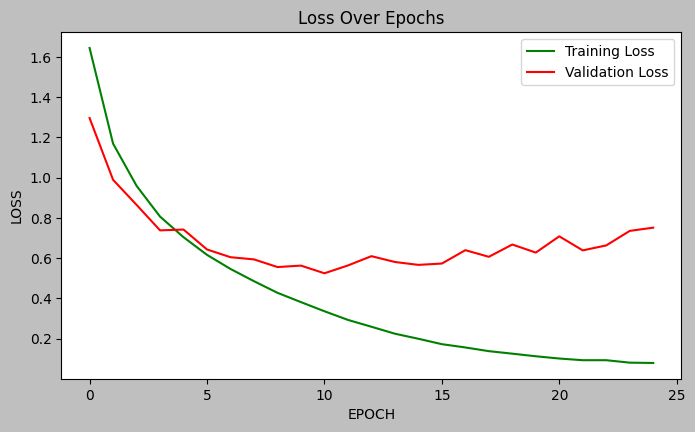

In [12]:
torch.manual_seed(RANDOM_SEED)

model = ModernAlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.7284, Test Accuracy: 0.8370


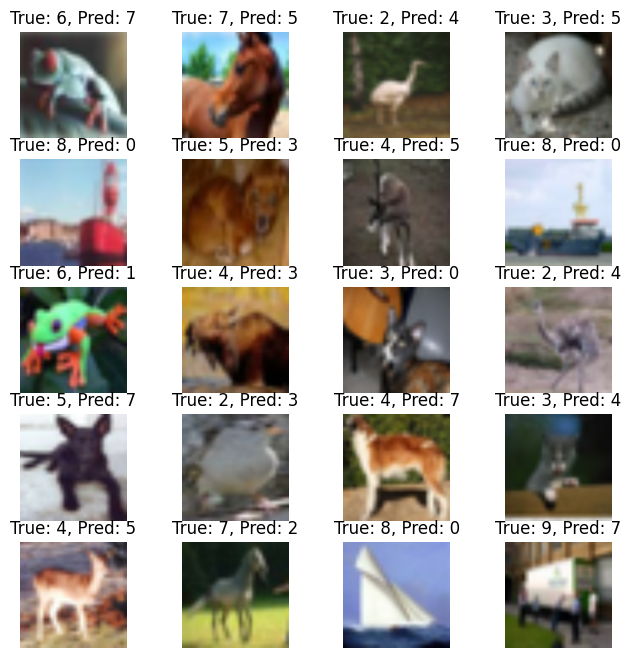

In [13]:
import matplotlib.pyplot as plt

# 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 틀린 예시를 저장
def test_and_collect_mistakes(test_loader, model, criterion, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    mistakes = []

    with torch.no_grad():  # 평가시에는 그래디언트 계산 불필요
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파와 손실 기록하기
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)

            # 예측 및 정확도 계산
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 틀린 예시 저장
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

    epoch_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return epoch_loss, accuracy, all_preds, all_labels, mistakes

# 모델 학습이 완료된 후 평가 수행
test_loss, test_accuracy, test_preds, test_labels, mistakes = test_and_collect_mistakes(test_loader, model, criterion, DEVICE)

# 틀린 예시 시각화
def plot_mistakes(mistakes, num_examples=20):
    plt.figure(figsize=(8, 8))
    for i, (image, true_label, pred_label) in enumerate(mistakes[:num_examples]):
        plt.subplot(5, 4, i + 1)
        plt.axis('off')
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()

# 틀린 예시 출력
plot_mistakes(mistakes)
